In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import sys
import math
import glob
import os
import random
from statsmodels.stats.multitest import multipletests  
from scipy import stats
import seaborn as sns
import statsmodels

# import classifiers
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from scipy.ndimage import gaussian_filter1d
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold

import mne
from mne.preprocessing import EOGRegression
from mne.defaults import HEAD_SIZE_DEFAULT
from mne.channels._standard_montage_utils import _read_theta_phi_in_degrees

# set root directories
dir                 = '/home/amber/OneDrive/code/nAdaptation_EEG_analysis/' # to save figures
dir_data            = '/home/amber/OneDrive/FMG3275_object_in_noise/eeg/dataCollection2024/pilot4/'
dir_behaviour       = '/home/amber/OneDrive/FMG3275_object_in_noise/behaviour/dataCollection2024/pilot4/'

# extract eeg files
eeg_files = sorted(glob.glob(dir_data + '*.bdf'))
print(eeg_files)

# extract behaviour files
behaviour_files = sorted(glob.glob(dir_behaviour + '*.txt'))
print(behaviour_files)

# determine 
assert len(eeg_files) == len(behaviour_files) # throws error if number of eeg files doesn't match number of behavioural files
n_sub = len(eeg_files)

for i in range(len(eeg_files)):
    assert behaviour_files[i][-9:-4] == eeg_files[i][-9:-4]

# exclude subjects
exclude = []
n_sub = len(eeg_files)

print('\nNumber of subjects: ', n_sub - len(exclude))

fontsize_title          = 15
fontsize_legend         = 10
fontsize_label          = 12
fontsize_tick           = 10

['/home/amber/OneDrive/FMG3275_object_in_noise/eeg/dataCollection2024/pilot4/05032024_eeg_sub20.bdf', '/home/amber/OneDrive/FMG3275_object_in_noise/eeg/dataCollection2024/pilot4/05032024_eeg_sub21.bdf', '/home/amber/OneDrive/FMG3275_object_in_noise/eeg/dataCollection2024/pilot4/06032024_eeg_sub22.bdf', '/home/amber/OneDrive/FMG3275_object_in_noise/eeg/dataCollection2024/pilot4/06032024_eeg_sub23.bdf', '/home/amber/OneDrive/FMG3275_object_in_noise/eeg/dataCollection2024/pilot4/08032024_eeg_sub24.bdf', '/home/amber/OneDrive/FMG3275_object_in_noise/eeg/dataCollection2024/pilot4/13022024_eeg_sub01.bdf', '/home/amber/OneDrive/FMG3275_object_in_noise/eeg/dataCollection2024/pilot4/13022024_eeg_sub02.bdf', '/home/amber/OneDrive/FMG3275_object_in_noise/eeg/dataCollection2024/pilot4/20022024_eeg_sub04.bdf', '/home/amber/OneDrive/FMG3275_object_in_noise/eeg/dataCollection2024/pilot4/20022024_eeg_sub06.bdf', '/home/amber/OneDrive/FMG3275_object_in_noise/eeg/dataCollection2024/pilot4/21022024_eeg_s

In [2]:
# montage - creates visualization of cap when figures are plotted with mne functions
fname = dir + 'config/chs.tsv'
montage = _read_theta_phi_in_degrees(fname=fname, head_size=HEAD_SIZE_DEFAULT,
                                    fid_names=['Nz', 'LPA', 'RPA'],
                                    add_fiducials=False)

# set reference electrodes
reference       = ['EMGL', 'EMGR']
eog             = ['EOGL', 'EOGR', 'EOGT', 'EOGB']
exc             = ['EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet', 'Temp']

In [10]:
# settings
tmin                = -0.1
tmax                = 1
sample_rate         = 2048
down_sample_rate    = 128

# band-pass frequencies
f_low       = 0.1           # high-pass filter
f_high      = 30            # low-pass filter

f_notch     = 50            # notch filter

# targets
targets                 = [3, 6, 8, 9]
n_targets               = len(targets)

# bootstrap
CI                  = 95
CI_low              = 50 - (0.5*CI)
CI_high             = 50 + (0.5*CI)
B_repetitions       = 1000

# set timepoints
if down_sample_rate == 64:
    n_timepoints            = math.floor((abs(tmin) + tmax)/(1/down_sample_rate))
else:
    n_timepoints            = math.ceil((abs(tmin) + tmax)/(1/down_sample_rate))
t                       = np.arange(n_timepoints)*(1/down_sample_rate)+tmin
print(len(t))

# channel info
n_channels      = 64

global channel_names # (e.g. Oz, Fp1) will be added later in the loop over subjects

# number of repetitions
n_repeats_clean                 = 100
n_repeats_noisy                 = 8

# initiate dataframe
adapters                    = ['none', 'same', 'different']
adapters_color              = ['gray', 'dodgerblue', np.array([212, 170, 0])/255]

contrasts                   = ['l_contrast', 'lm_contrast', 'm_contrast', 'mh_contrast', 'h_contrast']
cmap                        = plt.cm.get_cmap('cool')
contrasts_color             = cmap(np.linspace(0, 1, len(contrasts)))

141


/tmp/ipykernel_8020/3877937503.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap                        = plt.cm.get_cmap('cool')


### Retrieve data

In [4]:
mne.set_log_level('WARNING') # suppresses warnings from MNE (less output)

# initiate dataframes for decoding analysis
data_clean      = np.zeros((n_sub, n_targets, n_repeats_clean, n_channels, n_timepoints))
data_noisy      = np.zeros((n_sub, len(adapters), len(contrasts), n_targets, n_repeats_noisy, n_channels, n_timepoints))

# retrieve data
for iS in range(n_sub):
# for iS in range(1):

    print('Subject ', iS+1, '...')

    # import behaviour file
    df_behaviour_current = pd.read_csv(behaviour_files[iS])

    # import raw data
    raw = mne.io.read_raw_bdf(eeg_files[iS], eog=eog, misc=reference, exclude=exc, preload=True)
    channel_names = raw.info['ch_names'][:n_channels]

    # reference signal to mastoids
    raw.set_eeg_reference(reference)

    # apply band-pass and notch filter
    raw.notch_filter(freqs=(f_notch))
    raw.filter(l_freq=f_low, h_freq=f_high)

    # set electrode montage
    raw.set_montage(montage)

    # find all events
    events = mne.find_events(raw)

    ######################### CLEAN
    ##############################################################
    ##############################################################

    # sort trials in the order they were presented
    df_behaviour_sorted = df_behaviour_current.sort_values('trial_order')

    # select data rows
    idx = df_behaviour_sorted[(df_behaviour_sorted.trial_type == 'clean')].index
    df_behaviour_sorted = df_behaviour_sorted.loc[idx, :]
    df_behaviour_sorted.reset_index(drop=True, inplace=True)
    trigger_num = df_behaviour_sorted.loc[:, 'trigger_num'].unique().tolist()
    # print(df_behaviour_sorted)

    # select noisy events
    events_noisy = mne.pick_events(events, include=trigger_num)

    # create epochs
    if down_sample_rate == None:
        epochs = mne.Epochs(raw, events_noisy, baseline=(tmin, 0), picks=['eeg', 'eog'], tmin=tmin, tmax=tmax, preload='True')
    else:
        epochs = mne.Epochs(raw, events_noisy, baseline=(tmin, 0), picks=['eeg', 'eog'], tmin=tmin, tmax=tmax, preload='True').resample(down_sample_rate, npad='auto')

    # transform to current source density (CSD) - noisy
    epochs_clean_plain_csd = mne.preprocessing.compute_current_source_density(epochs)

    for iT, target in enumerate(targets):

        # extract noisy images
        index = df_behaviour_sorted[(df_behaviour_sorted.target_class == target)].index
        # print(len(index))

        # rerieve data (events x channels x timepoints)
        data_current = epochs_clean_plain_csd.get_data(picks=channel_names)
        data_clean[iS, iT, :, :, :] = data_current[index, :, :]

    ######################### NOISY
    ##############################################################
    ##############################################################

    # sort trials in the order they were presented
    df_behaviour_sorted = df_behaviour_current.sort_values('trial_order')

    # select data rows
    idx = df_behaviour_sorted[((df_behaviour_sorted.trial_type == 'repeated') | (df_behaviour_sorted.trial_type == 'single')) & (df_behaviour_sorted.img_type == 'test')].index
    df_behaviour_sorted = df_behaviour_sorted.loc[idx, :]
    df_behaviour_sorted.reset_index(drop=True, inplace=True)
    trigger_num = df_behaviour_sorted.loc[:, 'trigger_num'].unique().tolist()
    # print(df_behaviour_sorted)

    # select noisy events
    events_noisy = mne.pick_events(events, include=trigger_num)

    # create epochs
    if down_sample_rate == None:
        epochs = mne.Epochs(raw, events_noisy, baseline=(tmin, 0), picks=['eeg', 'eog'], tmin=tmin, tmax=tmax, preload='True')
    else:
        epochs = mne.Epochs(raw, events_noisy, baseline=(tmin, 0), picks=['eeg', 'eog'], tmin=tmin, tmax=tmax, preload='True').resample(down_sample_rate, npad='auto')

    # transform to current source density (CSD) - noisy
    epochs_clean_plain_csd = mne.preprocessing.compute_current_source_density(epochs)

    for iA, adapter in enumerate(adapters):
        for iC, contrast in enumerate(contrasts):
            for iT, target in enumerate(targets):

                # extract noisy images
                if adapter == 'none':
                    index = df_behaviour_sorted[(df_behaviour_sorted.trial_type == 'single') & (df_behaviour_sorted.contrast == contrast) & (df_behaviour_sorted.target_class == target)].index
                else:
                    index = df_behaviour_sorted[(df_behaviour_sorted.trial_type == 'repeated') & (df_behaviour_sorted.adapter == adapter) & (df_behaviour_sorted.contrast == contrast) & (df_behaviour_sorted.target_class == target)].index
                # print(len(index))
        
                # rerieve data (events x channels x timepoints)
                data_current = epochs_clean_plain_csd.get_data(picks=channel_names)
                data_noisy[iS, iA, iC, iT, :, :, :] = data_current[index, :, :]

# clean images
np.save(dir + 'data/dataCollection2024/' + str(down_sample_rate) + 'Hz/decoding_clean_data', data_clean)

# noisy images
np.save(dir + 'data/dataCollection2024/' + str(down_sample_rate) + 'Hz/decoding_noisy_data', data_noisy)


In [4]:
# clean images
data_clean = np.load(dir + 'data/dataCollection2024/' + str(down_sample_rate) + 'Hz/decoding_clean_data.npy')

# noisy images
data_noisy = np.load(dir + 'data/dataCollection2024/' + str(down_sample_rate) + 'Hz/decoding_noisy_data.npy')


## Decode clean images

Training classifier

In [5]:
# number of splits for k-fold cross validation
n_split     = 10

# initiate dataframe
decoding_accu_clean = np.ones((n_sub, n_timepoints)) * 0.25

# sliding window
window_clean      = 4
print('Time window: ', np.round(2*window_clean*(1/down_sample_rate)*1000, 2), 'ms')

# avarege over n trials
clean_trial_avg       = 2

# average every n trials
data_clean_avg      = np.zeros((n_sub, n_targets, int(n_repeats_clean/clean_trial_avg), n_channels, n_timepoints))
for iR in range(int(n_repeats_clean/clean_trial_avg)):
    start = iR*clean_trial_avg
    data_clean_avg[:, :, iR, :, :] = data_clean[:, :, start:start+clean_trial_avg, :, :].mean(2)

# create labels
df = pd.DataFrame(columns=['target', 'repeats'])
for iT, target in enumerate(targets):
    for iR in range(int(n_repeats_clean/clean_trial_avg)):
        df.loc[len(df), :] = [target, int(n_repeats_clean/clean_trial_avg)]
print(len(df))

for iS in range(n_sub):
# for iS in range(5):

    print('Current subject: ', iS+1)

    for tmp in range(window_clean, n_timepoints):

        # select data
        if window_clean == 0:
            current_data = data_clean_avg[iS, :, :, :, tmp]
        else:
            current_data = data_clean_avg[iS, :, :, :, tmp-window_clean:tmp+window_clean].mean(3)
        current_data = current_data.reshape(current_data.shape[0]*current_data.shape[1], current_data.shape[2])

        # cross-validation
        kf = KFold(n_splits=n_split, shuffle=True)

        # store accuracies for current split
        accu_current_split = list()
        for k, (train_index, test_index) in enumerate(kf.split(current_data, df.loc[:, 'target'].tolist())):

            # initiate classifier
            # clf = GaussianNB()
            clf = clf = svm.SVC()

            # fit
            X_train     = current_data[train_index, :]
            X_test      = current_data[test_index, :]

            # train classifier
            clf.fit(X_train, df.loc[train_index, 'target'].tolist())

            # predict
            pred = clf.predict(X_test)

            # save accuracy
            accu_current_split.append((pred == df.loc[test_index, 'target'].tolist()).sum()/len(df.loc[test_index, 'target'].tolist()))

        # save accuracy     
        decoding_accu_clean[iS, tmp] = np.mean(accu_current_split)

Time window:  62.5 ms
200
Current subject:  1
Current subject:  2
Current subject:  3
Current subject:  4
Current subject:  5
Current subject:  6
Current subject:  7
Current subject:  8
Current subject:  9
Current subject:  10
Current subject:  11
Current subject:  12
Current subject:  13
Current subject:  14
Current subject:  15
Current subject:  16
Current subject:  17
Current subject:  18
Current subject:  19
Current subject:  20
Current subject:  21


In [6]:
# store p-values
p_values_adjust_clean = np.ones(n_timepoints)

# # non-parametric
# data_current                = decoding_accu_clean
# resampled_datasets          = np.zeros((B_repetitions, n_timepoints))

# for iB in range(B_repetitions):
#     bootstrap_indices               = np.random.choice(n_sub, n_sub, replace=True)
#     current_sample = np.zeros((n_sub, n_timepoints))
#     for iS in range(n_sub):
#         current_sample[iS, :]       = data_current[bootstrap_indices[iS], :]
#     resampled_datasets[iB, :]          = np.median(current_sample, 0)

# testing
for tmp in range(window_clean, n_timepoints):

    # parametric
    results = stats.ttest_1samp(decoding_accu_clean[:, tmp], 0.25)
    p_values_adjust_clean[tmp] = results[1]

    # # nonp-parametric
    # sample1 = np.ones(B_repetitions)*0.25
    # sample2 = resampled_datasets[:, tmp]
    # diffs   = sample1 - sample2

    # p_values_adjust_clean[tmp] = np.min([len(diffs[diffs < 0]), len(diffs[diffs > 0])])/B_repetitions

# MC correction
p_values_adjust_sign_clean = multipletests(p_values_adjust_clean, method='fdr_bh')
p_values_adjusted_sign_clean = np.argwhere(p_values_adjust_clean < 0.01).flatten()
print(len(p_values_adjusted_sign_clean))

81


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


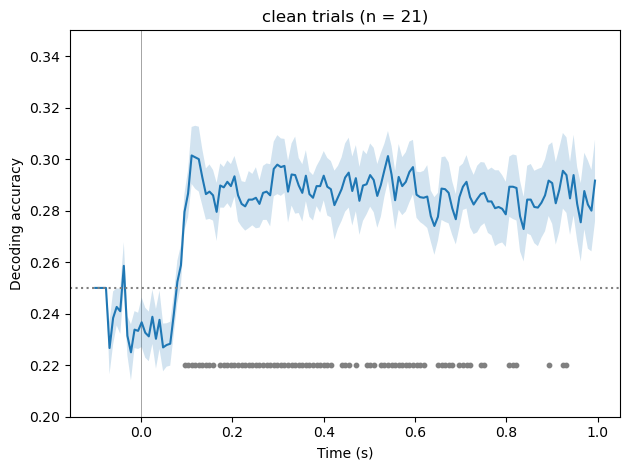

In [20]:
# initiate figure
fig = plt.figure()
ax = plt.gca()

# plot decoding accuracies
data_mean = np.mean(decoding_accu_clean[:, :], 0)
data_std = np.std(decoding_accu_clean[:, :], 0)/math.sqrt(n_sub)

# plot data
# ax.plot(t, decoding_accu_clean.T, color='dodgerblue', lw=0.5)
ax.plot(t, data_mean)
ax.fill_between(t, data_mean - data_std, data_mean + data_std, alpha=0.2)

# adjust axes
ax.axhline(1/len(targets), linestyle='dotted', color='grey')
ax.axvline(0, lw=0.5, color='grey', zorder=-10)
ax.axhline(0, lw=0.5, color='grey', zorder=-10)
ax.set_ylim(0.2, 0.35)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Decoding accuracy')
ax.legend(frameon=False)

# plot stats
ax.scatter(t[p_values_adjusted_sign_clean], np.ones(len(p_values_adjusted_sign_clean))*0.22, s=10, color='grey')

plt.title('clean trials (n = ' + str(n_sub) + ')')
plt.tight_layout()
plt.savefig(dir + 'visualizations/decoding/decoding_performance', dpi=300)

## Decode noisy images

In [43]:
# sliding window
window_noisy      = 5
print('Time window: ', np.round(2*window_noisy*(1/down_sample_rate)*1000, 2), 'ms')

# intiate dataframe to store decoding accuracies
decoding_accu_noisy       = np.ones((n_sub, len(adapters), len(contrasts), n_timepoints)) * 0.25

# initiate dataframe
adapters                    = ['none', 'same', 'different']
contrasts                   = ['l_contrast', 'lm_contrast', 'm_contrast', 'mh_contrast', 'h_contrast']

# avarege over n trials
noisy_trial_avg       = 2
print(n_repeats_noisy/noisy_trial_avg)

# average every n trials
data_noise_avg      = np.zeros((n_sub, len(adapters), len(contrasts), n_targets, int(n_repeats_noisy/noisy_trial_avg), n_channels, n_timepoints))
for iR in range(int(n_repeats_noisy/noisy_trial_avg)):
    start = iR*noisy_trial_avg
    data_noise_avg[:, :, :, :, iR, :, :] = data_noisy[:, :, :, :, start:start+noisy_trial_avg, :, :].mean(4)

# initiate dataframe
df = pd.DataFrame(columns=['adapter', 'contrast', 'target', 'repeats'])

# add data
for iA, adapter in enumerate(adapters):
    for iC, contrast in enumerate(contrasts):
        for iT, target in enumerate(targets):
            for iR in range(int(n_repeats_noisy/noisy_trial_avg)):
                df.loc[len(df), :] = [adapter, contrast, target, iR+1]
print(len(df))

for iS in range(n_sub):
# for iS in range(1):

    # print progress
    print('Current subject: ', iS+1)

    for tmp in range(window_noisy, n_timepoints):

        # select data
        if window_noisy == 0:
            current_data = data_noise_avg[iS, :, :, :, :, :, tmp]
        else:
            current_data = data_noise_avg[iS, :, :, :, :, :, tmp-window_noisy:tmp+window_noisy].mean(5)
        current_data = current_data.reshape(current_data.shape[0]*current_data.shape[1]*current_data.shape[2]*current_data.shape[3], current_data.shape[4])
        # print(current_data.shape)

        for iA, adapter in enumerate(adapters):
            for iC, contrast in enumerate(contrasts):

                # initiate classifier
                # clf = GaussianNB()
                clf = clf = svm.SVC()

                # select train and test indices
                test_index = df[(df.adapter == adapter) & (df.contrast == contrast)].index                
                train_index = [num for num in np.arange(len(df)) if num not in test_index]
                            
                # select dataa
                X_train = current_data[train_index, :]
                X_test = current_data[test_index, :]
                
                # fit classifier
                # print(df.loc[train_index, 'target'])
                clf.fit(X_train, df.loc[train_index, 'target'].tolist())

                # predict
                pred = clf.predict(X_test)

                # # save accuracy
                decoding_accu_noisy[iS, iA, iC, tmp] = (pred == df.loc[test_index, 'target']).sum()/len(df.loc[test_index, 'target'])

Time window:  78.12 ms
4.0
240
Current subject:  1
Current subject:  2
Current subject:  3
Current subject:  4
Current subject:  5
Current subject:  6
Current subject:  7
Current subject:  8
Current subject:  9
Current subject:  10
Current subject:  11
Current subject:  12
Current subject:  13
Current subject:  14
Current subject:  15
Current subject:  16
Current subject:  17
Current subject:  18
Current subject:  19
Current subject:  20
Current subject:  21


In [41]:
# store p-values
p_values_adjust_noisy = np.ones(n_timepoints)

# # non-parametric
# data_current                = decoding_accu_noisy.mean(1).mean(1)
# resampled_datasets          = np.zeros((B_repetitions, n_timepoints))

# for iB in range(B_repetitions):
#     bootstrap_indices               = np.random.choice(n_sub, n_sub, replace=True)
#     current_sample = np.zeros((n_sub, n_timepoints))
#     for iS in range(n_sub):
#         current_sample[iS, :]       = data_current[bootstrap_indices[iS], :]
#     resampled_datasets[iB, :]          = np.median(current_sample, 0)

# testing
for tmp in range(window_noisy, n_timepoints):

    # parametric
    results = stats.ttest_1samp(decoding_accu_noisy[:, :, :, tmp].mean(1).mean(1), 0.25)
    p_values_adjust_noisy[tmp] = results[1]

    # # nonp-parametric
    # sample1 = np.ones(B_repetitions)*0.25
    # sample2 = resampled_datasets[:, tmp]
    # diffs   = sample1 - sample2

    # p_values_adjust_noisy[tmp] = np.min([len(diffs[diffs < 0]), len(diffs[diffs > 0])])/B_repetitions

# MC correction
p_values_adjust_sign_noisy = multipletests(p_values_adjust_noisy, method='fdr_bh')
p_values_adjust_sign_noisy = np.argwhere(p_values_adjust_noisy < 0.05).flatten()
print(len(p_values_adjust_sign_noisy))

63


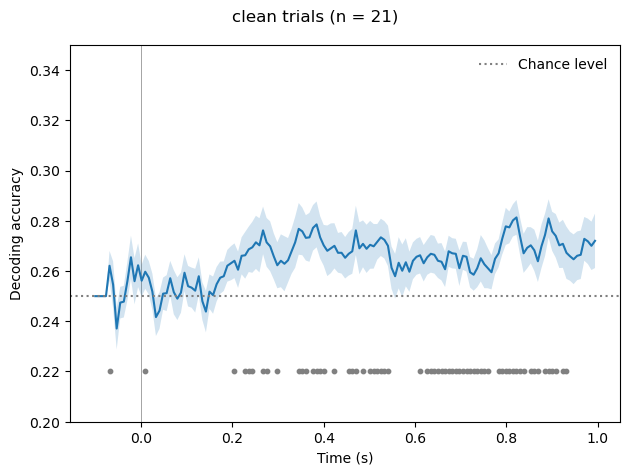

In [42]:
# initiate figure
fig = plt.figure()
ax = plt.gca()

# select data
data_current = decoding_accu_noisy[:, :, :, :].mean(1).mean(1)

# plot decoding accuracies
data_mean = np.mean(data_current, 0)
data_std = np.std(data_current, 0)/math.sqrt(n_sub)

# plot data
ax.plot(t, data_mean)
ax.fill_between(t, data_mean - data_std, data_mean + data_std, alpha=0.2)

# plot stats
ax.scatter(t[p_values_adjust_sign_noisy], np.ones(len(p_values_adjust_sign_noisy))*0.22, s=10, color='grey')

# adjust axes
ax.axhline(1/len(targets), linestyle='dotted', color='grey', label='Chance level')
ax.axvline(0, lw=0.5, color='grey', zorder=-10)
ax.axhline(0, lw=0.5, color='grey', zorder=-10)
ax.set_ylim(0.2, 0.35)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Decoding accuracy')
ax.legend(frameon=False)

plt.suptitle('clean trials (n = ' + str(n_sub) + ')')
plt.tight_layout()
plt.savefig(dir + 'visualizations/decoding/decoding_performance_adapter', dpi=300)

## Visualize

Mean decoding accuracy - clean:  0.2828608923884514
STD decoding accuracy - clean:  0.012145317167807906
Mean decoding accuracy - noisy:  0.2652262217222847
STD decoding accuracy - noisy:  0.008451844366979506


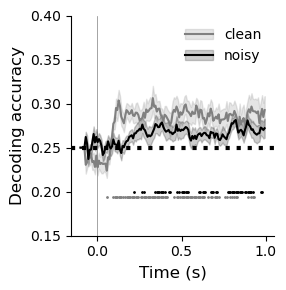

In [34]:
t_start     = np.argwhere(t > 0.0)[0][0]
t_end       = np.argwhere(t > 0.99)[0][0]

# initiate figure
fig = plt.figure(figsize=(3, 3))
ax = plt.gca()

patchs      = list()
lines       = list()

######################################## NOISY

color = 'grey'

# select data
data_current = decoding_accu_clean

print('Mean decoding accuracy - clean: ', np.mean(data_current[:, t_start:t_end]))
print('STD decoding accuracy - clean: ', np.std(data_current[:, t_start:t_end])/math.sqrt(n_sub))

# plot decoding accuracies
data_mean = np.mean(data_current, 0)
data_std = np.std(data_current, 0)/math.sqrt(n_sub)

# plot data
line, = ax.plot(t, data_mean, color=color, label='clean')
patch = ax.fill_between(t, data_mean - data_std, data_mean + data_std, color=color, alpha=0.2)
patchs.append(patch)
lines.append(line)

# plot stats
ax.scatter(t[p_values_adjusted_sign_clean], np.ones(len(p_values_adjusted_sign_clean))*0.20-0.006, s=1, color=color)#, transform=ax.transAxes)

######################################## CLEAN

color = 'black'

# select data
data_current = decoding_accu_noisy[:, :, :, :].mean(1).mean(1)

print('Mean decoding accuracy - noisy: ', np.mean(data_current[:, t_start:t_end]))
print('STD decoding accuracy - noisy: ', np.std(data_current[:, t_start:t_end])/math.sqrt(n_sub))

# plot decoding accuracies
data_mean = np.mean(data_current, 0)
data_std = np.std(data_current, 0)/math.sqrt(n_sub)

# plot data
line, = ax.plot(t, data_mean, color=color, label='noise')
patch = ax.fill_between(t, data_mean - data_std, data_mean + data_std, color=color, alpha=0.2)
patchs.append(patch)
lines.append(line)

# plot stats
ax.scatter(t[p_values_adjust_sign_noisy], np.ones(len(p_values_adjust_sign_noisy))*0.20, s=1, color=color)#, transform=ax.transAxes)

########################################

# adjust axes
ax.tick_params(axis='both', labelsize=fontsize_tick)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axhline(1/len(targets), linestyle='dotted', color='black', lw=3, label='Chance level')
ax.axvline(0, lw=0.5, color='grey', zorder=-10)
ax.axhline(0, lw=0.5, color='grey', zorder=-10)
ax.set_ylim(0.15, 0.4)
ax.set_xlabel('Time (s)', fontsize=fontsize_label)
ax.set_ylabel('Decoding accuracy', fontsize=fontsize_label)
ax.legend([(lines[0], patchs[0]), (lines[1], patchs[1])], ['clean', 'noisy'], fontsize=fontsize_legend, frameon=False)

# plt.suptitle('clean trials (n = ' + str(n_sub) + ')')
plt.tight_layout()
plt.savefig(dir + 'visualizations/decoding/decoding_performance', dpi=300)
plt.savefig(dir + 'visualizations/decoding/decoding_performance.svg')

adapter

0
30
22


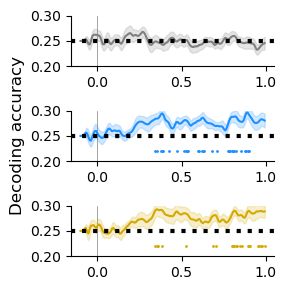

In [37]:
# initiate figure
fig, ax = plt.subplots(len(adapters), 1, figsize=(3,3))
# ax = plt.gca()

# legend
patchs = list()
lines = list()

adapters_plot = ['none', 'same', 'different']

for iA, adapter in enumerate(adapters):

    # select data
    data_current = decoding_accu_noisy[:, iA, :, :].mean(1)

    # plot decoding accuracies
    data_mean = gaussian_filter1d(np.mean(data_current, 0), 1)
    data_std = gaussian_filter1d(np.std(data_current, 0)/math.sqrt(n_sub), 1)

    # # plot decoding accuracies
    # data_mean = np.mean(data_current, 0)
    # data_std = np.std(data_current, 0)/math.sqrt(n_sub)

    # plot data
    line, = ax[iA].plot(t, data_mean, color=adapters_color[iA], label=adapter)
    patch = ax[iA].fill_between(t, data_mean - data_std, data_mean + data_std, color=adapters_color[iA], alpha=0.2)
    lines.append(line)
    patchs.append(patch)

    # store p-values
    p_values_adjust_noisy = np.ones(n_timepoints)

    # # non-parametric
    # print(data_current.shape)
    # resampled_datasets          = np.zeros((B_repetitions, n_timepoints))

    # for iB in range(B_repetitions):
    #     bootstrap_indices               = np.random.choice(n_sub, n_sub, replace=True)
    #     current_sample                  = np.zeros((n_sub, n_timepoints))
    #     for iS in range(n_sub):
    #         current_sample[iS, :]       = data_current[bootstrap_indices[iS], :]
    #     resampled_datasets[iB, :]       = np.mean(current_sample, 0)

    # testing
    for tmp in range(window_noisy, n_timepoints):

        # parametric
        results = stats.ttest_1samp(decoding_accu_noisy[:, iA, :, tmp].mean(1), 0.25)
        p_values_adjust_noisy[tmp] = results[1]

        # # # nonp-parametric
        # sample1 = np.ones(B_repetitions)*0.25
        # sample2 = resampled_datasets[:, tmp]
        # diffs   = sample1 - sample2

        # p_values_adjust_noisy[tmp] = np.min([len(diffs[diffs < 0]), len(diffs[diffs > 0])])/B_repetitions

    # FDR correction
    # p_values_adjust_noisy = stats.false_discovery_control(p_values_adjust_noisy)
    # print(p_values_adjust_noisy)
    p_values_adjust_sign_noisy = multipletests(p_values_adjust_noisy, method='sidak')
    p_values_adjust_sign_noisy = np.argwhere(p_values_adjust_noisy < 0.01).flatten()
    print(len(p_values_adjust_sign_noisy))
    # print(p_values_adjust_sign_noisy)

    ax[iA].scatter(t[p_values_adjust_sign_noisy], np.ones(len(p_values_adjust_sign_noisy))*0.22, s=1, color=adapters_color[iA])

    # adjust axes
    ax[iA].tick_params(axis='both', labelsize=fontsize_tick)
    ax[iA].spines['top'].set_visible(False)
    ax[iA].spines['right'].set_visible(False)
    ax[iA].axhline(1/len(targets), linestyle='dotted', color='black', lw=3, label='Chance level')
    ax[iA].axvline(0, lw=0.5, color='grey', zorder=-10)
    # ax[iA].axhline(0, lw=0.5, color='grey', zorder=-10)
    ax[iA].set_ylim(0.2, 0.3)
    # ax[iA].set_xlabel('Time (s)', fontsize=fontsize_label)
    if iA == 1:
        ax[iA].set_ylabel('Decoding accuracy', fontsize=fontsize_label)
    # ax[iA].legend([(lines[-1], patchs[-1])], [adapters_plot[iA]], fontsize=fontsize_legend, frameon=False)
    
    
# ax[iA].legend([(lines[0], patchs[0]), (lines[1], patchs[1]), (lines[2], patchs[2])], ['none', 'same', 'different'], fontsize=fontsize_legend, frameon=False)

# plt.suptitle('clean trials (n = ' + str(n_sub) + ')')
plt.tight_layout()
plt.savefig(dir + 'visualizations/decoding/decoding_performance_adapter', dpi=300)
plt.savefig(dir + 'visualizations/decoding/decoding_performance_adapter.svg')

contrast

15
1
25
21
39


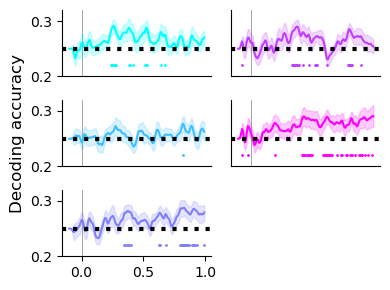

In [39]:
# initiate figure
fig, ax = plt.subplots(3, 2, figsize=(4, 3))
# ax = plt.gca()
ax[2, 1].axis('off')

# legend
patchs = list()
lines = list()

# visualize
iC = 0
for j in range(2):
    for i in range(3):
    
        if (j == 1) & (i == 2):
            continue

        # select data
        data_current = decoding_accu_noisy[:, :, iC, :].mean(1)

        # plot decoding accuracies
        data_mean = gaussian_filter1d(np.mean(data_current, 0), 1)
        data_std = gaussian_filter1d(np.std(data_current, 0)/math.sqrt(n_sub), 1)

        # plot data
        line, = ax[i, j].plot(t, data_mean, color=contrasts_color[iC], label=contrast)
        patch = ax[i, j].fill_between(t, data_mean - data_std, data_mean + data_std, color=contrasts_color[iC], alpha=0.2)
        lines.append(line)
        patchs.append(patch)

        # store p-values
        p_values_adjust_noisy = np.ones(n_timepoints)

        # # non-parametric
        # data_current                = decoding_accu_noisy[:, :, iC, :].mean(1)
        # # print(data_current)
        # resampled_datasets          = np.zeros((B_repetitions, n_timepoints))

        # for iB in range(B_repetitions):
        #     bootstrap_indices               = np.random.choice(n_sub, n_sub, replace=True)
        #     current_sample = np.zeros((n_sub, n_timepoints))
        #     for iS in range(n_sub):
        #         current_sample[iS, :]       = data_current[bootstrap_indices[iS], :]
        #     resampled_datasets[iB, :]       = np.mean(current_sample, 0)

        # testing
        for tmp in range(window_noisy, n_timepoints):

            # parametric
            results = stats.ttest_1samp(decoding_accu_noisy[:, :, iC, tmp].mean(1), 0.25)
            p_values_adjust_noisy[tmp] = results[1]

            # # nonp-parametric
            # sample1 = np.ones(B_repetitions)*0.25
            # sample2 = resampled_datasets[:, tmp]
            # diffs   = sample1 - sample2

            # p_values_adjust_noisy[tmp] = np.min([len(diffs[diffs < 0]), len(diffs[diffs > 0])])/B_repetitions

        # FDR correction
        # p_values_adjust_noisy = stats.false_discovery_control(p_values_adjust_noisy)
        p_values_adjust_sign_noisy = multipletests(p_values_adjust_noisy, method='bonferroni')
        p_values_adjust_sign_noisy = np.argwhere(p_values_adjust_noisy < 0.05).flatten()
        print(len(p_values_adjust_sign_noisy))

        ax[i, j].scatter(t[p_values_adjust_sign_noisy], np.ones(len(p_values_adjust_sign_noisy))*0.22, s=1, color=contrasts_color[iC])#, transform=ax.transAxes)

        # adjust axes
        ax[i, j].tick_params(axis='both', labelsize=fontsize_tick)
        ax[i, j].spines['top'].set_visible(False)
        ax[i, j].spines['right'].set_visible(False)
        ax[i, j].axhline(1/len(targets), linestyle='dotted', color='black', lw=3, label='Chance level')
        ax[i, j].axvline(0, lw=0.5, color='grey', zorder=-10)
        ax[i, j].axhline(0, lw=0.5, color='grey', zorder=-10)
        ax[i, j].set_ylim(0.2, 0.32)
        if (i == 1) & (j == 0):
            ax[i, j].set_ylabel('Decoding accuracy', fontsize=fontsize_label)
        if (i != 2):
            ax[i, j].set_xticks([])
        if (j != 0):
            ax[i, j].set_yticks([])

        # increment count
        iC = iC + 1

# ax.legend([(lines[0], patchs[0]), (lines[1], patchs[1]), (lines[2], patchs[2]), (lines[3], patchs[3]), (lines[4], patchs[4])], ['50%', '60%', '70%', '80%', '90%'], fontsize=fontsize_legend, frameon=False, ncol=2)

# plt.suptitle('clean trials (n = ' + str(n_sub) + ')')
plt.tight_layout()
plt.savefig(dir + 'visualizations/decoding/decoding_performance_contrast', dpi=300)
plt.savefig(dir + 'visualizations/decoding/decoding_performance_contrast.svg')